In [163]:
%matplotlib inline

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_probability as tfp
import functions as fns
import importlib
importlib.reload(fns)

# tensorflow의 래핑 라이브러리인 keras에서 본 튜토리얼에 사용할 기능들
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Input

# matplotlib의 기능들
plt.style.use('seaborn-whitegrid')
plt.rc('font', family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)

In [164]:
# ./data 폴더의 BloombergMain.py(융기원 코드)를 통해 생성한 csv파일을 불러온다.
data = pd.read_csv('data.csv', index_col=0, parse_dates=True)
df = fns.preprocessing(data)
df.to_csv('data_preprocessed.csv')

In [165]:
# 로그수익율로 전처리 완료된 파일을 불러온다.
dr = pd.read_csv('data_preprocessed.csv', index_col=0, parse_dates=True)
# dr = pd.read_csv('data_preprocessed_2(50stock).csv', index_col=0, parse_dates=True)

print(dr.index)

DatetimeIndex(['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04', '2011-02-07', '2011-02-08', '2011-02-09',
               '2011-02-10', '2011-02-11',
               ...
               '2022-04-27', '2022-04-28', '2022-04-29', '2022-05-02',
               '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06',
               '2022-05-09', '2022-05-10'],
              dtype='datetime64[ns]', name='Date', length=2839, freq=None)


In [166]:
# train / test set 준비 - train data : test data = 80 : 20
train_index = int(dr.shape[0]*0.8)
print(train_index)
# 80:20 으로 train / test 분할 (numpy array로 변환)
train_data = dr[:train_index].values
train_date = dr[:train_index].index.values.astype('datetime64[D]')
print("train data index")
print(dr[:train_index].index)
test_data = dr[train_index:].values
test_date = dr[train_index:].index.values.astype('datetime64[D]')
print("test data index")
print(dr[train_index:].index)


2271
train data index
DatetimeIndex(['2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
               '2011-02-04', '2011-02-07', '2011-02-08', '2011-02-09',
               '2011-02-10', '2011-02-11',
               ...
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07'],
              dtype='datetime64[ns]', name='Date', length=2271, freq=None)
test data index
DatetimeIndex(['2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-18', '2020-02-19', '2020-02-20',
               '2020-02-21', '2020-02-24',
               ...
               '2022-04-27', '2022-04-28', '2022-04-29', '2022-05-02',
               '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06',
               '2022-05-09', '2022-05-10'],
              dtype='datetime64[ns]', name='Date', length=568, freq=None)


In [167]:
# 자산배분비율 산출 기준 : 과거 60일 데이터로 산출, 미래 20일의 최적수익율로 최적화
window_size_past=30
window_size_future=10
xc_train, xf_train = fns.make_data_window(train_data, window_size_past, window_size_future)
xc_test, xf_test = fns.make_data_window(test_data, window_size_past, window_size_future)


In [168]:
model, history = fns.model_build_fit(xc_train, xf_train, xc_test, xf_test, 250)

Epoch 1/250
70/70 [==============================] - 2s 15ms/step - loss: 0.0079 - val_loss: -0.0062
Epoch 2/250
70/70 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: -0.0051
Epoch 3/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: -0.0061
Epoch 4/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0069 - val_loss: -0.0061
Epoch 5/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: -0.0064
Epoch 6/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0064 - val_loss: -0.0050
Epoch 7/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: -0.0057
Epoch 8/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0054 - val_loss: -0.0059
Epoch 9/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: -0.0064
Epoch 10/250
70/70 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: -0.00

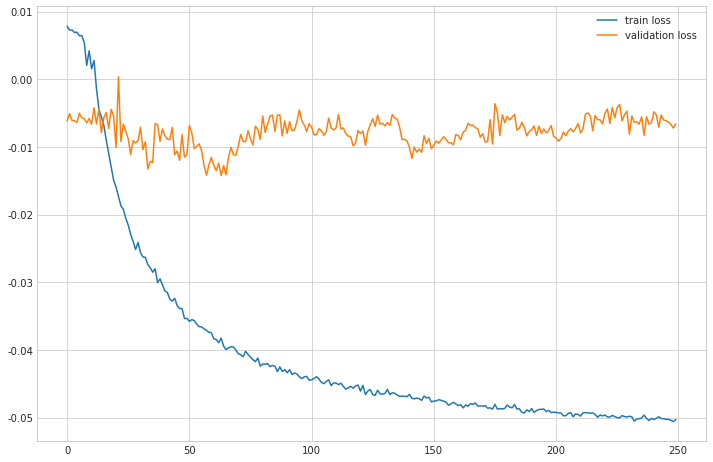

In [169]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [7]:
xc_all, xf_all = fns.make_data_window(dr.values, 60, 20)

In [8]:
from sklearn.model_selection import train_test_split
xc_train2, xc_test2, xf_train2, xf_test2 = train_test_split(xc_all, xf_all, test_size=0.2, shuffle=True, random_state=42)

In [9]:
xf_train2.shape

(1304, 20, 51)

In [10]:
model, history = fns.model_build_fit(xc_train2, xf_train2, xc_test2, xf_test2, 70)

Epoch 1/70
41/41 [==============================] - 3s 26ms/step - loss: -0.0108 - val_loss: -0.0024
Epoch 2/70
41/41 [==============================] - 1s 18ms/step - loss: -0.0120 - val_loss: -0.0028
Epoch 3/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0128 - val_loss: -0.0024
Epoch 4/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0129 - val_loss: -0.0046
Epoch 5/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0139 - val_loss: -0.0055
Epoch 6/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0153 - val_loss: -0.0061
Epoch 7/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0167 - val_loss: -0.0085
Epoch 8/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0187 - val_loss: -0.0108
Epoch 9/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0209 - val_loss: -0.0131
Epoch 10/70
41/41 [==============================] - 1s 17ms/step - loss: -0.0222 - val_los

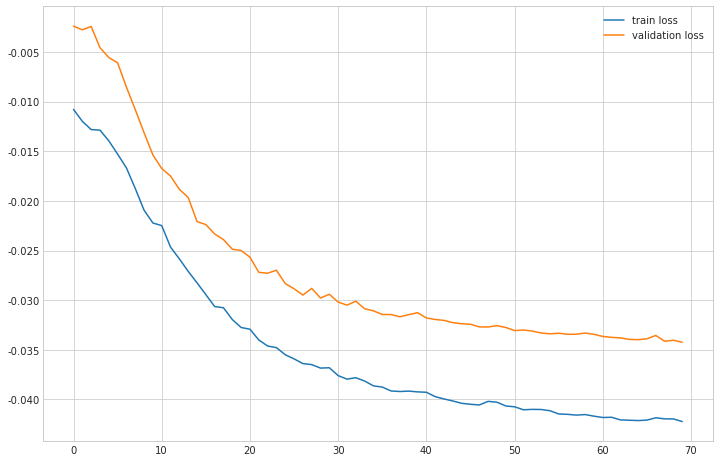

In [11]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [13]:
from sklearn.model_selection import KFold
X = dr.values
kf = KFold(n_splits=5, shuffle=False)

In [14]:
model_list = []
history_list = []
for train_index, test_index in kf.split(X):
    train_data, test_data = X[train_index], X[test_index]
    # 자산배분비율 산출 기준 : 과거 60일 데이터로 산출, 미래 20일의 최적수익율로 최적화
    xc_train, xf_train = fns.make_data_window(train_data, 60, 20)
    xc_test, xf_test = fns.make_data_window(test_data, 60, 20)
    model, history = fns.model_build_fit(xc_train, xf_train, xc_test, xf_test, 70)
    model_list.append(model)
    history_list.append(history)

Epoch 1/70
69/69 [==============================] - 3s 24ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 2/70
69/69 [==============================] - 1s 16ms/step - loss: 0.0044 - val_loss: 0.0098
Epoch 3/70
69/69 [==============================] - 1s 16ms/step - loss: 0.0033 - val_loss: 0.0115
Epoch 4/70
69/69 [==============================] - 1s 16ms/step - loss: 0.0025 - val_loss: 0.0108
Epoch 5/70
69/69 [==============================] - 1s 16ms/step - loss: 0.0011 - val_loss: 0.0122
Epoch 6/70
69/69 [==============================] - 1s 16ms/step - loss: 2.6832e-04 - val_loss: 0.0153
Epoch 7/70
69/69 [==============================] - 1s 16ms/step - loss: -7.7265e-04 - val_loss: 0.0123
Epoch 8/70
69/69 [==============================] - 1s 16ms/step - loss: -0.0012 - val_loss: 0.0093
Epoch 9/70
69/69 [==============================] - 1s 16ms/step - loss: -0.0025 - val_loss: 0.0117
Epoch 10/70
69/69 [==============================] - 1s 17ms/step - loss: -0.0019 - val_loss: 0.01

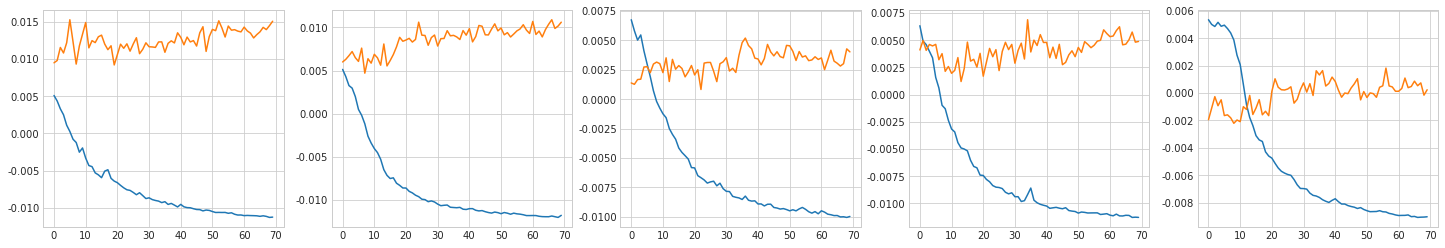

In [17]:
fig, ax = plt.subplots(1,5,figsize=(25,4))
for i, history in enumerate(history_list):
    ax[i].plot(history.history['loss'], label='train loss')
    ax[i].plot(history.history['val_loss'], label='validation loss')

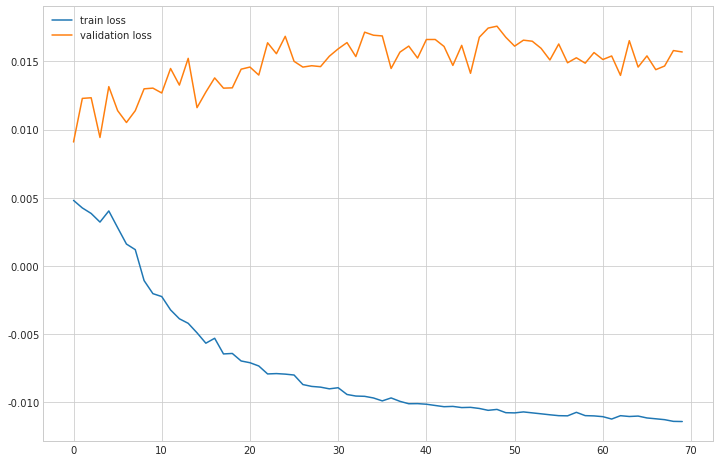

In [17]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(history_list[0].history['loss'], label='train loss')
plt.plot(history_list[0].history['val_loss'], label='validation loss')
plt.legend()
plt.show()

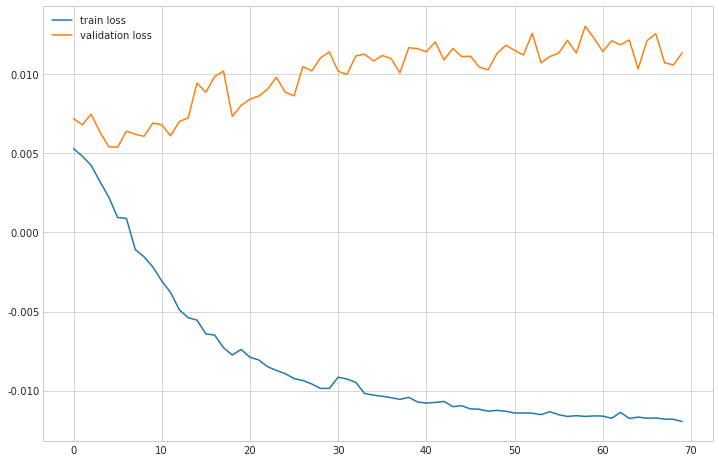

In [18]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(history_list[1].history['loss'], label='train loss')
plt.plot(history_list[1].history['val_loss'], label='validation loss')
plt.legend()
plt.show()

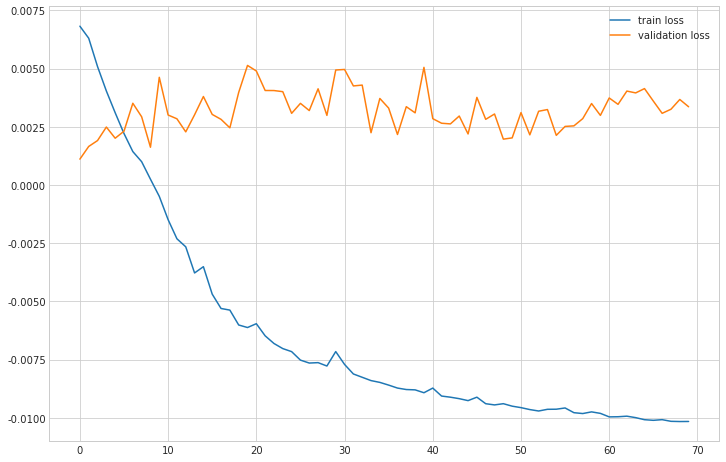

In [19]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(history_list[2].history['loss'], label='train loss')
plt.plot(history_list[2].history['val_loss'], label='validation loss')
plt.legend()
plt.show()

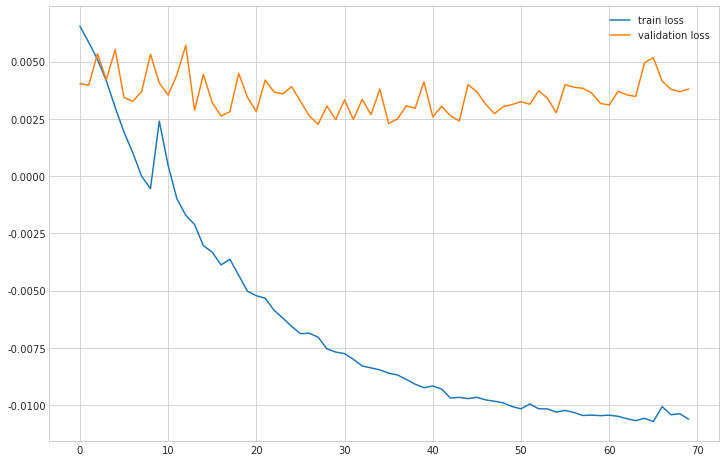

In [21]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(history_list[3].history['loss'], label='train loss')
plt.plot(history_list[3].history['val_loss'], label='validation loss')
plt.legend()
plt.show()

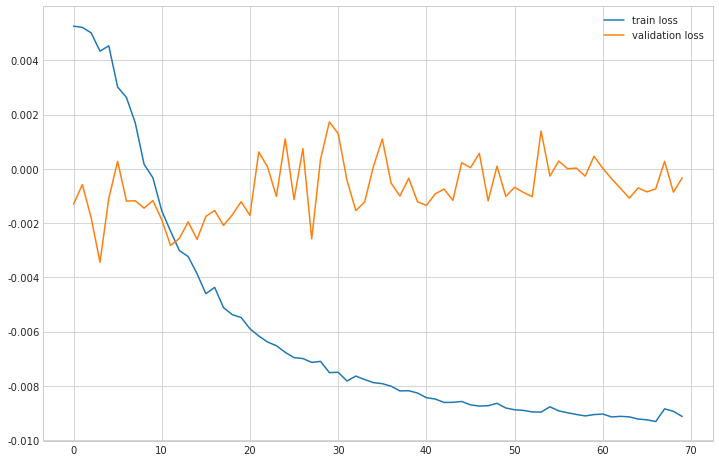

In [22]:
# loss trajectory를 확인한다.
plt.figure(figsize=(12,8))
plt.plot(history_list[4].history['loss'], label='train loss')
plt.plot(history_list[4].history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
tickers = dr.columns.values
tickers

In [ ]:
train_data.shape

In [ ]:
xc_train_date = train_date[:len(train_date)-window_size_past-window_size_future]
xc_train_date

In [ ]:
print("xc_train.shape:",xc_train.shape)
print("xf_train.shape:",xf_train.shape)
print("xc_test.shape:",xc_test.shape)
print("xf_test.shape:",xf_test.shape)

In [ ]:
print("xc_train.shape:",xc_train2.shape)
print("xf_train.shape:",xf_train2.shape)
print("xc_test.shape:",xc_test2.shape)
print("xf_test.shape:",xf_test2.shape)

## MPN(Markowitz Portfolio Network) 만들기

### 주요 상수 설정

In [ ]:
# 월간 수익율 정도의 스케일로 변환한다.(아마퀀트님 코드)
# scikit-learn 의 scaler 를 사용하는게 낫지 않을까?
xc_train_scaled = xc_train2.astype('float32') * 20.0
xf_train_scaled = xf_train2.astype('float32') * 20.0
xc_test_scaled = xc_test2.astype('float32') * 20.0
xf_test_scaled = xf_test2.astype('float32') * 20.0

xc_train_scaled_old = xc_train.astype('float32') * 20.0
xf_train_scaled_old = xf_train.astype('float32') * 20.0
xc_test_scaled_old = xc_test.astype('float32') * 20.0
xf_test_scaled_old = xf_test.astype('float32') * 20.0

N_TIME = xc_train_scaled.shape[1]
N_FUTURE = xf_train_scaled.shape[1]
N_STOCKS = xf_train_scaled.shape[2]

# 입력 순서에 따른 상관성을 제거하기 위해 sklearn.utils의 함수를 이용해서 shuffle을 수행한다.
xc_train_scaled, xf_train_scaled = shuffle(xc_train_scaled, xf_train_scaled)


SAVE_MODEL = 'mpn.h5'

In [ ]:
N_TIME, N_FUTURE

### 모델 학습

In [ ]:
# MPN을 학습하고 결과를 저장한다.
hist = model.fit(xc_train_scaled, xf_train_scaled, epochs=70, batch_size=32, validation_data=(xc_test_scaled, xf_test_scaled))
model.save(SAVE_MODEL)

### 학습결과 확인(loss)

### 최적 투자비율 추정

In [ ]:
def check_w(n=0):
    plt.figure(figsize=(12,8))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    # plt.bar(np.arange(N_STOCKS), y_pred, alpha=0.7)
    plt.bar(tickers, y_pred, alpha=0.7)
    plt.xticks(rotation=90)
    plt.show()

check_w(0)

In [ ]:
check_w(20)

## 성능 평가

In [ ]:
# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'mpn.h5'
model = load_model(SAVE_MODEL, compile = False)
model.summary()


## Backtesting

In [ ]:
# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
spy_value = [10000]
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)
w_spy = np.zeros(N_STOCKS)
w_spy[9] = 1

w_history = []
date_history = [test_date[0]] # 시작일을 저장한다.

for i in range(0, xc_test_scaled_old.shape[0], N_FUTURE):
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    # x = xc_test[i][np.newaxis,:,:] * 20.0
    x = xc_test_scaled_old[i][np.newaxis,:,:]
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    date_history.append(test_date[i+N_TIME])

    # 다음 기의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0)

    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    # print(f"m_rtn: {m_rtn}")
    # print(f"w_prt: {w_prt}")
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    spy_value.append(crp_value[-1] * np.exp(np.dot(w_spy, m_rtn)))


In [ ]:
np_w_history = np.array(w_history)


In [ ]:
pd.DataFrame(data=np_w_history, index=date_history[1:], columns=tickers).plot(figsize=(16,8), stacked=True, kind='bar')

In [ ]:
prt_value

In [ ]:
crp_value

In [ ]:
spy_value

In [ ]:

# 평가 시점의 날짜를 발췌한다.
# idx = np.arange(0, len(test_date), N_FUTURE)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
# perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value}, index=test_date[idx])
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'spy':spy_value}, index=date_history)

In [ ]:
perf_df.plot(figsize=(12,8))